# Análise de Dados Exploratória da ANAC

![ANAC](imgs/anac-logo.png "Logo ANAC")

# 1. Introdução

Este estudo tem como objetivo analisar um conjunto de dados de voos internacionais registrados pela Agência Nacional de Aviação Civil (ANAC) do Brasil, durante o período de janeiro de 2015 a agosto de 2017. 

A ANAC é a agência reguladora responsável pela aviação civil no país, e as informações contidas nesses dados são de grande importância para a compreensão da dinâmica da aviação internacional no Brasil, bem como para a tomada de decisões estratégicas no setor. O conjunto de dados inclui informações como o número do voo, nome da companhia aérea, horários de partida e chegada previstos e reais, situação do voo e localização dos aeroportos de origem e destino, entre outros. Esses dados permitem uma análise detalhada das tendências e padrões de voos internacionais no Brasil, bem como a identificação de fatores que possam influenciar o desempenho da aviação internacional no país.

## 1.1. Objetivos

O objetivo deste estudo é realizar uma Análise Exploratória dos Dados (Exploratory Data Analysis - EDA) do conjunto de dados disposto em [bases/](bases/), e analisar dados de voos internacionais rastreados pela ANAC.

Com base nas informações disponíveis, pretendemos avaliar o desempenho das companhias aéreas em relação ao cumprimento dos horários previstos de partida e chegada, bem como investigar a frequência de cancelamentos e as justificativas apresentadas para esses casos. 

Também vamos examinar as rotas mais utilizadas e os destinos mais comuns para os voos internacionais saindo do Brasil, bem como avaliar a pontualidade e a eficiência dos aeroportos de origem e destino. 

1. [Análise 1](#Análise1)
2. [Análise 2](#Análise2)
3. [Análise 3](#Análise3)
4. [Análise 4](#Análise4)


# 2. Metodologia

Nesta seção será apresentado todo o processo de preparação, organização e limpeza de dados feito no *dataset* que possui os seguintes dados brutos. Ao final desta, apresentaremos os dados padronizados e devidamente tratados:

|        Coluna        | Tipo |                         Descrição                         |
|:--------------------:|:----:|:---------------------------------------------------------:|
|         Voos         |  str |                       Número do voo                       |
|    Companhia.Aerea   |  str |                  Nome da companhia aérea                  |
|   Codigo.Tipo.Linha  |  str |          Código do tipo de linha (internacional)          |
|   Partida.Prevista   |  str |                Horário previsto de partida                |
|     Partida.Real     |  str |                  Horário real de partida                  |
|   Chegada.Prevista   |  str |                Horário previsto de chegada                |
|     Chegada.Real     |  str |                  Horário real de chegada                  |
|     Situacao.Voo     |  str |        Situação do voo (realizado, cancelado, etc)        |
| Codigo.Justificativa |  str | Código de justificativa (caso o voo tenha sido cancelado) |
|   Aeroporto.Origem   |  str |               Código do aeroporto de origem               |
|     Cidade.Origem    |  str |                      Cidade de origem                     |
|     Estado.Origem    |  str |                      Estado de origem                     |
|      Pais.Origem     |  str |                       País de origem                      |
|   Aeroporto.Destino  |  str |               Código do aeroporto de destino              |
|    Cidade.Destino    |  str |                     Cidade de destino                     |
|    Estado.Destino    |  str |                     Estado de destino                     |
|     Pais.Destino     |  str |                      País de destino                      |
|       LongDest       |  str |             Longitude do aeroporto de destino             |
|        LatDest       |  str |              Latitude do aeroporto de destino             |
|       LongOrig       |  str |              Longitude do aeroporto de origem             |
|        LatOrig       |  str |              Latitude do aeroporto de origem              |


## 2.1. Configuração do Ambiente

### 2.1.1. Bibliotecas e Ferramentas Necessárias (Built-ins)

1. ```os```:       Para manipular os arquivos de base e seus respectivos diretórios de forma multiplataforma e eficiente.
2. ```re```:       Utilizado em expressões regulares durante o processo de limpeza dos dados.
3. ```enum```:     Auxilia nos processos de padronizar e regular algumas convenções do projeto.
4. ```datetime```: Auxilia nos processos de padronizar e regular algumas convenções do projeto

### 2.1.2. Bibliotecas e Ferramentas Necessárias (pip)

1. Pandas: Para manipular e exibir os dados de forma coesa e relata.   
    ```pip install pandas```       
    ```import pandas as pd```

2. JinJa2: Complemento de estilização do Pandas.   
    ```pip install Jinja2```

3. Matplotlib: Para exibição visual dos dados por meio de gráficos.   
    ```pip install matplotlib```   
    ```import matplotlib.pyplot as plt```

4. DescricaoColuna e DescricaoTipo: São classes estáticas compostar por Enums estabelecidos com base nas convenções de nome das colunas do *dataset*.   
   **Utils** possui complementos para tratativas de alguns campos.   
    ```from libs.utils import Utils```

### 2.1.3. Importações gerais para o projeto

In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplcyberpunk
from libs.utils import Utils
from IPython.display import display

## 2.2. Carregamento da base

In [2]:
caminho = os.path.join(
            os.path.dirname(
                os.path.abspath(
                    os.path.join(__name__, '.'))), 'bases')

arquivos = [arquivo for arquivo in os.listdir(caminho) if arquivo.endswith(".csv")]

dataframes = [pd.read_csv(os.path.join(caminho, arquivo)) for arquivo in arquivos]

flights_dataframe = pd.concat(dataframes)

## 2.3. Organização e Limpeza dos Dados

### 2.3.1. Padrozinação dos nomes das colunas

In [3]:
nomes_colunas_tratadas = []

for coluna in flights_dataframe.columns:
    if any(char.isupper() for char in coluna):
        if coluna == 'Voos': coluna = 'Num.Voo'
        nomes_colunas_tratadas.append('_'.join(word.lower() for word in re.findall('[A-Z][^A-Z]*', coluna)).lower().replace('.', ''))

flights_dataframe.columns = nomes_colunas_tratadas

### 2.3.2. Padrozinação dos tipos das colunas de data/hora, string e númericos

In [4]:
for coluna in flights_dataframe.columns:
    tipo = Utils.tipo_coluna(coluna)
    if tipo.__name__ == 'datetime': 
        flights_dataframe = Utils.formatar_colunas_datetime(flights_dataframe, coluna)

### 2.3.3. Padrozinação no nome das companhias aérea.

In [5]:
flights_dataframe['companhia_aerea'] = flights_dataframe.apply(
    lambda row: Utils.nome_companhia_aerea_normalizado(
        row['companhia_aerea'], 
        ), axis=1)

### 2.3.4. Feature Engineering
A engenharia de recursos (*Feature Engineering*) é o processo de usar o conhecimento do domínio para extrair recursos dos dados brutos. Neste estudo serão acrescentadas as seguintes colunas para enriquecer a análise de dados:

| Coluna         | Descrição                                                            | Base         |
|:--------------:|:--------------------------------------------------------------------:|:--------------:|
| partida_atrasou | Houve atraso na partida (S/N)                                       | `partida_prevista - partida_real` |
| chegada_atrasou | Houve atraso na chegada (S/N)                                       | `chegada_prevista - chegada_real` |
| distancia_km   | Distância total em kms da origem ao destino                          | `lat_long_orig - lat_long_dest` |
| justificativa_atraso   | Informação e correlata à justificativa no atraso do voo      | `codigo_justificativa` |
| justificativa_cancelamento   | Informação e correlata à justificativa do cancelamento do voo| `codigo_justificativa` |


#### 2.3.3.1. Atraso na partida

In [6]:
flights_dataframe['partida_atrasou'] = flights_dataframe.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'], 
        row['partida_prevista'], 
        row['partida_real']
        ), axis=1)

#### 2.3.3.2. Atraso na chegada

In [7]:
flights_dataframe['chegada_atrasou'] = flights_dataframe.apply(
    lambda row: Utils.validar_atraso(
        row['situacao_voo'], 
        row['chegada_prevista'], 
        row['chegada_real']
        ), axis=1)

#### 2.3.3.3. distancia_km (para *lat_long_orig* e *lat_long_dest*)

In [8]:
flights_dataframe['distancia_km'] = flights_dataframe.apply(
    lambda row: Utils.calcular_distancia_km(
    row['lat_orig'],
    row['long_orig'],
    row['lat_dest'],
    row['long_dest']
    ), axis=1)

#### 2.3.3.4. Justificativa atraso

In [9]:
flights_dataframe['justificativa_atraso'] = ''
flights_dataframe['justificativa_atraso'] = np.where(
    ((flights_dataframe['partida_atrasou'] == 'S') | (flights_dataframe['chegada_atrasou'] == 'S')),
    flights_dataframe.apply(lambda row: Utils.motivo_atraso(row['codigo_justificativa']), axis=1),
    flights_dataframe['justificativa_atraso']
)

#### 2.3.3.5. Justificativa cancelamento

In [10]:
flights_dataframe['justificativa_cancelamento'] = ''
flights_dataframe['justificativa_cancelamento'] = np.where(
    flights_dataframe['situacao_voo'] == 'Cancelado',
    flights_dataframe.apply(lambda row: Utils.motivo_cancelamento(row['codigo_justificativa']), axis=1),
    flights_dataframe['justificativa_cancelamento']
)

## 2.4. Mapeamento de Dados
Para melhorar a análise e interpretação dos dados os seguintes atributos serão modificados:

| Coluna    | Original     | Modificado                          |
|:----------:|:-------------:|:------------------------------------:|
| *    | 'NA', *      | '', *                  |
| *      | np.NaN / NaN      | ''                  |


### 2.4.1. Removendo 'N/I' por um valor ''/string.empty

In [11]:
for coluna in flights_dataframe.columns:
    flights_dataframe[coluna] = flights_dataframe[coluna].replace('N/I', '')

### 2.4.2. Removendo np.NaN por um valor None

In [12]:
flights_dataframe.fillna(value='', inplace=True)

### 2.5. Reordenando as colunas de forma semântica

In [13]:
flights_dataframe = flights_dataframe.reindex(columns=Utils.nomes_colunas(), index=None)
flights_dataframe.drop('codigo_justificativa', axis=1, inplace=True)

dataframe = flights_dataframe

### 2.6 Resultado final

In [14]:
columns = ['NomeColuna', 'DescricaoColuna', 'TipoColuna']
values = [[value, Utils.descricao_coluna(value), Utils.tipo_coluna(value).__name__] for value in dataframe.columns]

pd.DataFrame(data=values, columns=columns).style.set_table_styles([
            dict(selector='th', props=[('text-align', 'center')]), 
            dict(selector='td', props=[('text-align', 'center')])
            ])

,NomeColuna,DescricaoColuna,TipoColuna
0,num_voo,Número do voo,str
1,companhia_aerea,Nome da companhia aérea,str
2,codigo_tipo_linha,Código do tipo de linha (internacional),str
3,aeroporto_origem,Código do aeroporto de origem,str
4,cidade_origem,Cidade de origem,str
5,estado_origem,Estado de origem,str
6,pais_origem,País de origem,str
7,lat_orig,Latitude do aeroporto de origem,float
8,long_orig,Longitude do aeroporto de origem,float
9,partida_prevista,Horário previsto de partida,datetime


# 3. Análise dos Dados

## 3.1. Quantidade de voos por companhia aérea.
Verificar a quantidade de voos realizados por cada companhia aérea.

In [15]:
voos_por_cia_area = dataframe.groupby(['companhia_aerea', 'situacao_voo', 'codigo_tipo_linha', 'justificativa_atraso']).agg(
    voos_realizados=('situacao_voo', lambda x: ((x == 'Realizado') & (dataframe['justificativa_atraso'] == '')).sum()),
    voos_com_atraso=('situacao_voo', lambda x: ((x == 'Realizado') & (dataframe['justificativa_atraso'] != '')).sum()),
    voos_cancelados=('situacao_voo', lambda x: (x == 'Cancelado').sum())
).sort_values(
    by=['voos_realizados', 'voos_com_atraso', 'voos_cancelados'],
    ascending=False)

### 3.1.1. Quantidade de voos regionais por companhia aérea.

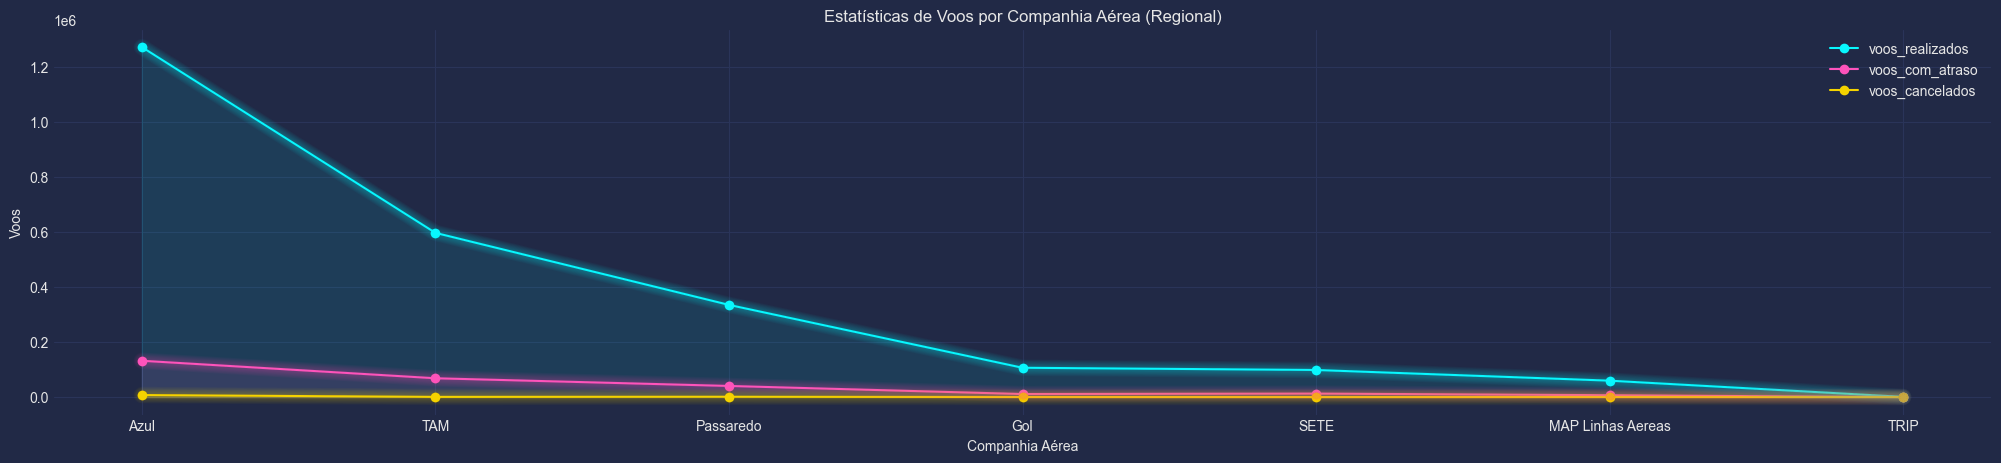

In [33]:
dados_grafico = voos_por_cia_area\
    .reset_index()\
    .loc[voos_por_cia_area.reset_index()['codigo_tipo_linha'] == 'Regional']\
    .groupby('companhia_aerea')\
    .agg(
        voos_realizados=('voos_realizados', 'sum'),
        voos_com_atraso=('voos_com_atraso', 'sum'),
        voos_cancelados=('voos_cancelados', 'sum')
).sort_values(by=['voos_realizados', 'voos_com_atraso', 'voos_cancelados'], ascending=False)

fig, ax = plt.subplots(figsize=(25,5))
dados_grafico.plot(kind='line', ax=ax, marker='o')

ax.set_title('Estatísticas de Voos por Companhia Aérea (Regional)')
ax.set_xlabel('Companhia Aérea')
ax.set_ylabel('Voos')
plt.style.use("cyberpunk")
mplcyberpunk.add_glow_effects()
plt.show()

del dados_grafico

### 3.1.2. Quantidade de voos nacionais por companhia aérea.

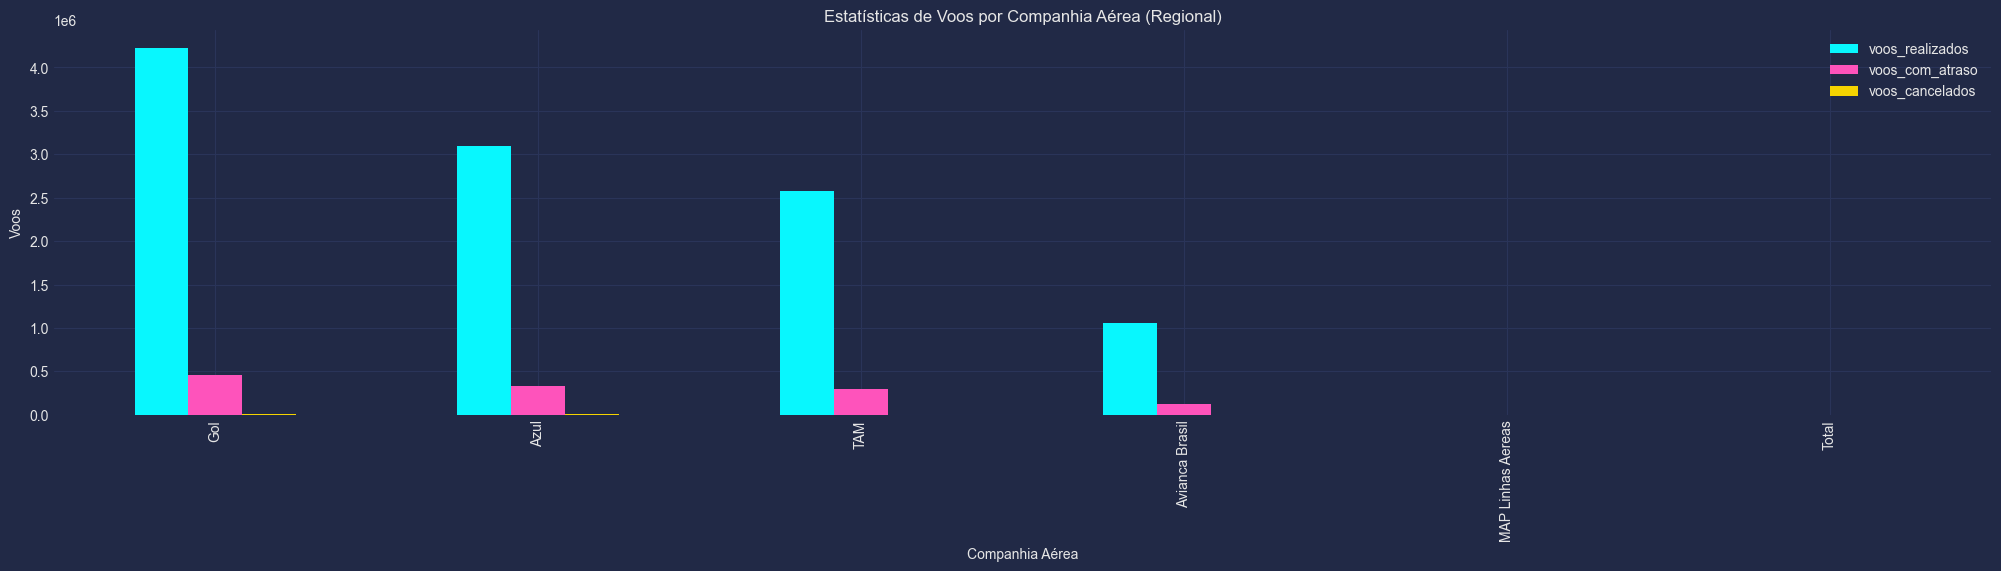

In [43]:
dados_grafico = voos_por_cia_area\
    .reset_index()\
    .loc[voos_por_cia_area.reset_index()['codigo_tipo_linha'] == 'Nacional']\
    .groupby('companhia_aerea')\
    .agg(
        voos_realizados=('voos_realizados', 'sum'),
        voos_com_atraso=('voos_com_atraso', 'sum'),
        voos_cancelados=('voos_cancelados', 'sum')
).sort_values(by=['voos_realizados', 'voos_com_atraso', 'voos_cancelados'], ascending=False)

fig, ax = plt.subplots(figsize=(25,5))
dados_grafico.plot(kind='bar', ax=ax)

ax.set_title('Estatísticas de Voos por Companhia Aérea (Regional)')
ax.set_xlabel('Companhia Aérea')
ax.set_ylabel('Voos')
plt.style.use("cyberpunk")
mplcyberpunk.make_lines_glow()
mplcyberpunk.add_underglow()
plt.show()

del dados_grafico

### 3.1.3. Quantidade de voos internacionais por companhia aérea.

In [18]:
voos_por_cia_area\
    .reset_index()\
    .loc[voos_por_cia_area.reset_index()['codigo_tipo_linha'] == 'Internacional']\
    .groupby('companhia_aerea')\
    .agg(
        voos_realizados=('voos_realizados', 'sum'),
        voos_com_atraso=('voos_com_atraso', 'sum'),
        voos_cancelados=('voos_cancelados', 'sum')
).sort_values(by=['voos_realizados', 'voos_com_atraso', 'voos_cancelados'], ascending=False)


,voos_realizados,voos_com_atraso,voos_cancelados
companhia_aerea,,,
TAM,392293,44711,183
Gol,251235,25810,262
American Airlines,176808,19419,107
Copa,154556,16318,18
TAP Air Portugal,106595,11723,76
Aerolineas Argentinas,82813,8904,92
AUSTRAL LINEAS AREAS CIELOS DEL SUR S.A,81812,8521,87
LAN Chile,70203,7828,0
Delta Airlines,69929,7233,43


## 3.2. Quantidade de voos por tipo de linha.
Verificar a quantidade de voos internacionais, nacionais e regionais, ou seja, analisar a distribuição de frequência da coluna 'Codigo.Tipo.Linha'.

## 3.3. Pontualidade dos voos.
Analisar a pontualidade dos voos, comparando a hora de partida prevista com a hora de partida real e a hora de chegada prevista com a hora de chegada real, utilizando gráficos de dispersão ou histogramas, e identificar os voos que tiveram maior atraso.

### 3.3.1 Pontualidade por companhia aérea.


### 3.3.2 Pontualidade por tipo de linha.


## 3.4. Frequência de voos cancelados.
Investigar a frequência de voos cancelados em função da justificativa apresentada na coluna 'Codigo.Justificativa'.

## 3.5. Correlação entre a localização dos aeroportos de origem e destino.
Analisar a correlação entre a localização dos aeroportos de origem e destino (latitude e longitude) e as companhias aéreas e tipo de linha dos voos utilizando gráficos de dispersão.

## 3.6. Aeroportos mais movimentados.
Identificar os aeroportos com maior quantidade de voos de partida e de chegada, utilizando gráficos de barras.

## 3.7. Distribuição geográfica dos voos internacionais
Analisar a distribuição geográfica dos voos internacionais em função dos países de origem e destino, utilizando mapas.